# Compute MDG survey results

This document will allow us to compute the MDG averages from the users and Krippendorf's alpha between them.

In [58]:
import pandas as pd
import json
import uuid

In [59]:
# data paths
csv_mdg_1_path = "../../evals/human/multi-dimension/results/twiga-mdg-1.csv"
csv_mdg_2_path = "../../evals/human/multi-dimension/results/twiga-mdg-2.csv"
csv_mdg_3_path = "../../evals/human/multi-dimension/results/twiga-mdg-3.csv"
json_mdg_path = "../../evals/human/multi-dimension/multi-dimension-survey.json"

## Convert the question list to a DataFrame per questionnaire

In [60]:
"""Read JSON file of queries into three separate mdg survey dataframes"""
with open(json_mdg_path, 'r') as file:
    data = json.load(file)

# Extract the relevant information and store it in a dictionary
mdg_queries_1_df = pd.DataFrame(data[0:12])
mdg_queries_2_df = pd.DataFrame(data[12:24])
mdg_queries_3_df = pd.DataFrame(data[24:36])

verbose = False
if verbose:
    print(mdg_queries_1_df.columns)
    print(mdg_queries_2_df.columns)
    print(mdg_queries_3_df.columns)

    print(len(mdg_queries_1_df))
    print(len(mdg_queries_2_df))
    print(len(mdg_queries_3_df))


## Convert the multi-dimension surveys into DataFrames

In [62]:
# Read the CSV file into a DataFrame, skipping two unnecessary rows

mdg_responses_1_df = pd.read_csv(csv_mdg_1_path, skiprows=[1,2])
mdg_responses_2_df = pd.read_csv(csv_mdg_2_path, skiprows=[1,2])
mdg_responses_3_df = pd.read_csv(csv_mdg_3_path, skiprows=[1,2])

# Assuming the first column is 'Name' and subsequent columns are responses
name_column = mdg_responses_2_df.columns[17]  # The title of the name column
sanity_check_columns = mdg_responses_2_df.columns[21:30] # TODO: get the actual query-response pair I made manually and show them somewhere along with these (can put in appendix)
response_columns = mdg_responses_2_df.columns[30:66] # The titles of the question columns and associated responses

def fill_data(mdg_df: pd.DataFrame, num_respondents:int) -> pd.DataFrame:
    data_dict = {
        "question_number": ["Q3","Q4","Q5","Q6","Q7","Q8","Q9","Q10","Q11","Q12","Q13","Q14"]*num_respondents,
        "respondent": [],
        "answer_relevance": [],
        "formulation": [],
        "suitability": []
    }
    for _, row in mdg_df.iterrows():
        name = row[name_column]
        name = uuid.uuid4()
        responses = row[response_columns].tolist()
        
        answer_relevance_responses = responses[::3]
        formulation_responses = responses[1::3]
        suitability_responses = responses[2::3]
        
        for ar, fr, sr in zip(answer_relevance_responses, formulation_responses, suitability_responses):
            data_dict["respondent"].append(name)
            data_dict["answer_relevance"].append(ar)
            data_dict["formulation"].append(fr)
            data_dict["suitability"].append(sr)
    
    return pd.DataFrame(data_dict)

mdg_1_data_df = fill_data(mdg_responses_1_df, 4)
mdg_2_data_df = fill_data(mdg_responses_2_df, 3)
mdg_3_data_df = fill_data(mdg_responses_3_df, 3)

## Merge the question description DataFrames and the response data DataFrames

In [63]:
# First expand the queries DataFrames to be the same length as the response DataFrames
mdg_queries_1_df_expanded = pd.concat([mdg_queries_1_df] * 4, ignore_index=True) # note that the first survey has 4 respondents
mdg_queries_2_df_expanded = pd.concat([mdg_queries_2_df] * 3, ignore_index=True)
mdg_queries_3_df_expanded = pd.concat([mdg_queries_3_df] * 3, ignore_index=True)

# Concatenate the DataFrames along the columns
mdg_queries_1_complete = pd.concat([mdg_queries_1_df_expanded, mdg_1_data_df], axis=1)
mdg_queries_2_complete = pd.concat([mdg_queries_2_df_expanded, mdg_2_data_df], axis=1)
mdg_queries_3_complete = pd.concat([mdg_queries_3_df_expanded, mdg_3_data_df], axis=1)

verbose = False
if verbose:
    print(mdg_queries_1_complete.columns)
    print(mdg_queries_2_complete.columns)
    print(mdg_queries_3_complete.columns)

mdg_queries_1_complete.to_csv("../../evals/human/multi-dimension/results/data1.csv")
mdg_queries_2_complete.to_csv("../../evals/human/multi-dimension/results/data2.csv")
mdg_queries_3_complete.to_csv("../../evals/human/multi-dimension/results/data3.csv")

## Create an index of questions per model

In [64]:
# Double check this directly in the survey
mdg_survey_1_index = {
    "baseline-gpt-3-5-turbo-16k-0613": [8,11],
    "assistant-gpt-3-5-turbo-16k-0613": [0,1,3,4,5,6,9],
    "pipeline-gpt-3-5-turbo-16k-0613": [2,7,10],
}

# Double check this directly in the survey
mdg_survey_2_index = {
    "baseline-gpt-3-5-turbo-16k-0613": [0,3,6,9,11],
    "assistant-gpt-3-5-turbo-16k-0613": [5,10],
    "pipeline-gpt-3-5-turbo-16k-0613": [1,2,4,7,8],
}

# Double check this directly in the survey
mdg_survey_3_index = {
    "baseline-gpt-3-5-turbo-16k-0613": [0,2,5,7,9],
    "assistant-gpt-3-5-turbo-16k-0613": [1,6,10],
    "pipeline-gpt-3-5-turbo-16k-0613": [3,4,8,11],
}

QUESTION_ID_CONVERSION = {
    0: "Q3",
    1: "Q4",
    2: "Q5",
    3: "Q6",
    4: "Q7",
    5: "Q8",
    6: "Q9",
    7: "Q10",
    8: "Q11",
    9: "Q12",
    10: "Q13",
    11: "Q14",
}

## Extract the relevant results for baseline

In [65]:
# List of question numbers to match in the respective surveys
baseline_match_1 = [QUESTION_ID_CONVERSION[query] for query in mdg_survey_1_index["baseline-gpt-3-5-turbo-16k-0613"]]
baseline_match_2 = [QUESTION_ID_CONVERSION[query] for query in mdg_survey_2_index["baseline-gpt-3-5-turbo-16k-0613"]]
baseline_match_3 = [QUESTION_ID_CONVERSION[query] for query in mdg_survey_3_index["baseline-gpt-3-5-turbo-16k-0613"]]

# Filter the DataFrame to only include rows where the 'Name' column matches any name in the list
baseline_df_1 = mdg_queries_1_complete[mdg_queries_1_complete['question_number'].isin(baseline_match_1)]
baseline_df_2 = mdg_queries_2_complete[mdg_queries_2_complete['question_number'].isin(baseline_match_2)]
baseline_df_3 = mdg_queries_3_complete[mdg_queries_3_complete['question_number'].isin(baseline_match_3)]

# Update the question_number identifiers
baseline_df_1['question_number'] = baseline_df_1['question_number']+"-survey-1"
baseline_df_2['question_number'] = baseline_df_2['question_number']+"-survey-2"
baseline_df_3['question_number'] = baseline_df_3['question_number']+"-survey-3"

# Concatenate the three DataFrames along the rows
baseline_df = pd.concat([baseline_df_1, baseline_df_2, baseline_df_3], axis=0, ignore_index=True)

baseline_df.to_csv("../../evals/human/multi-dimension/results/baseline_results.csv")

/var/folders/_6/wpldr7zj16g6s0l2mb0tl3f00000gn/T/ipykernel_16298/1927512174.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  baseline_df_1['question_number'] = baseline_df_1['question_number']+"-survey-1"
/var/folders/_6/wpldr7zj16g6s0l2mb0tl3f00000gn/T/ipykernel_16298/1927512174.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  baseline_df_2['question_number'] = baseline_df_2['question_number']+"-survey-2"
/var/folders/_6/wpldr7zj16g6s0l2mb0tl3f00000gn/T/ipykernel_16298/1927512174.py:14: SettingWith

## Extract the relevant results for assistant

In [66]:
# List of question numbers to match in the respective surveys
assistant_match_1 = [QUESTION_ID_CONVERSION[query] for query in mdg_survey_1_index["assistant-gpt-3-5-turbo-16k-0613"]]
assistant_match_2 = [QUESTION_ID_CONVERSION[query] for query in mdg_survey_2_index["assistant-gpt-3-5-turbo-16k-0613"]]
assistant_match_3 = [QUESTION_ID_CONVERSION[query] for query in mdg_survey_3_index["assistant-gpt-3-5-turbo-16k-0613"]]

# Filter the DataFrame to only include rows where the 'Name' column matches any name in the list
assistant_df_1 = mdg_queries_1_complete[mdg_queries_1_complete['question_number'].isin(assistant_match_1)]
assistant_df_2 = mdg_queries_2_complete[mdg_queries_2_complete['question_number'].isin(assistant_match_2)]
assistant_df_3 = mdg_queries_3_complete[mdg_queries_3_complete['question_number'].isin(assistant_match_3)]

# Update the question_number identifiers
assistant_df_1['question_number'] = assistant_df_1['question_number']+"-survey-1"
assistant_df_2['question_number'] = assistant_df_2['question_number']+"-survey-2"
assistant_df_3['question_number'] = assistant_df_3['question_number']+"-survey-3"

# Concatenate the three DataFrames along the rows
assistant_df = pd.concat([assistant_df_1, assistant_df_2, assistant_df_3], axis=0, ignore_index=True)

assistant_df.to_csv("../../evals/human/multi-dimension/results/assistant_results.csv")

/var/folders/_6/wpldr7zj16g6s0l2mb0tl3f00000gn/T/ipykernel_16298/114385570.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  assistant_df_1['question_number'] = assistant_df_1['question_number']+"-survey-1"
/var/folders/_6/wpldr7zj16g6s0l2mb0tl3f00000gn/T/ipykernel_16298/114385570.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  assistant_df_2['question_number'] = assistant_df_2['question_number']+"-survey-2"
/var/folders/_6/wpldr7zj16g6s0l2mb0tl3f00000gn/T/ipykernel_16298/114385570.py:14: SettingWit

## Extract the relevant results for pipeline

In [67]:
# List of question numbers to match in the respective surveys
pipeline_match_1 = [QUESTION_ID_CONVERSION[query] for query in mdg_survey_1_index["pipeline-gpt-3-5-turbo-16k-0613"]]
pipeline_match_2 = [QUESTION_ID_CONVERSION[query] for query in mdg_survey_2_index["pipeline-gpt-3-5-turbo-16k-0613"]]
pipeline_match_3 = [QUESTION_ID_CONVERSION[query] for query in mdg_survey_3_index["pipeline-gpt-3-5-turbo-16k-0613"]]

# Filter the DataFrame to only include rows where the 'Name' column matches any name in the list
pipeline_df_1 = mdg_queries_1_complete[mdg_queries_1_complete['question_number'].isin(pipeline_match_1)]
pipeline_df_2 = mdg_queries_2_complete[mdg_queries_2_complete['question_number'].isin(pipeline_match_2)]
pipeline_df_3 = mdg_queries_3_complete[mdg_queries_3_complete['question_number'].isin(pipeline_match_3)]

# Update the question_number identifiers
pipeline_df_1['question_number'] = pipeline_df_1['question_number']+"-survey-1"
pipeline_df_2['question_number'] = pipeline_df_2['question_number']+"-survey-2"
pipeline_df_3['question_number'] = pipeline_df_3['question_number']+"-survey-3"

# Concatenate the three DataFrames along the rows
pipeline_df = pd.concat([pipeline_df_1, pipeline_df_2, pipeline_df_3], axis=0, ignore_index=True)

pipeline_df.to_csv("../../evals/human/multi-dimension/results/pipeline_results.csv")

/var/folders/_6/wpldr7zj16g6s0l2mb0tl3f00000gn/T/ipykernel_16298/3273053532.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pipeline_df_1['question_number'] = pipeline_df_1['question_number']+"-survey-1"
/var/folders/_6/wpldr7zj16g6s0l2mb0tl3f00000gn/T/ipykernel_16298/3273053532.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pipeline_df_2['question_number'] = pipeline_df_2['question_number']+"-survey-2"
/var/folders/_6/wpldr7zj16g6s0l2mb0tl3f00000gn/T/ipykernel_16298/3273053532.py:14: SettingWith

## Get values of interest from the data

In [111]:
baseline_results = pd.read_csv("../../evals/human/multi-dimension/results/baseline_results.csv")
assistant_results = pd.read_csv("../../evals/human/multi-dimension/results/assistant_results.csv")
pipeline_results = pd.read_csv("../../evals/human/multi-dimension/results/pipeline_results.csv")

baseline_averages = baseline_results.groupby('source_file')[['answer_relevance', 'formulation', 'suitability']].mean()
assistant_averages = assistant_results.groupby('source_file')[['answer_relevance', 'formulation', 'suitability']].mean()
pipeline_averages = pipeline_results.groupby('source_file')[['answer_relevance', 'formulation', 'suitability']].mean()

# print(len(baseline_averages))
# print(assistant_averages.head())
# print(pipeline_averages.head())
results_df = pd.concat([baseline_averages, assistant_averages, pipeline_averages], axis=0, ignore_index=True)
print("Averages (0=baseline, 1=assistant, 2=pipeline)")
print(results_df)

1
Averages (0=baseline, 1=assistant, 2=pipeline)
   answer_relevance  formulation  suitability
0          4.184211     4.421053     4.184211
1          3.883721     3.627907     3.581395
2          4.000000     4.153846     4.153846


In [104]:
import numpy as np

# Calculate standard deviations
baseline_stds = baseline_results.groupby('source_file')[['answer_relevance', 'formulation', 'suitability']].std()
assistant_stds = assistant_results.groupby('source_file')[['answer_relevance', 'formulation', 'suitability']].std()
pipeline_stds = pipeline_results.groupby('source_file')[['answer_relevance', 'formulation', 'suitability']].std()

# Number of respondents per pipeline (assuming equal number of responses per pipeline for simplicity)
n_respondents_baseline = baseline_results.groupby('source_file').size()
n_respondents_assistant = assistant_results.groupby('source_file').size()
n_respondents_pipeline = pipeline_results.groupby('source_file').size()


# Calculate standard error of the mean (SEM) - 
sem_baseline = baseline_stds / np.sqrt(int(n_respondents_baseline))
sem_assistant = assistant_stds / np.sqrt(int(n_respondents_assistant))
sem_pipeline = pipeline_stds / np.sqrt(int(n_respondents_pipeline))

standard_errors_df = pd.concat([sem_baseline, sem_assistant, sem_pipeline], axis=0, ignore_index=True)
print("Standard mean (0=baseline, 1=assistant, 2=pipeline)")
print(standard_errors_df)



Standard mean (0=baseline, 1=assistant, 2=pipeline)
   answer_relevance  formulation  suitability
0          0.150179     0.089503     0.159370
1          0.163737     0.188317     0.156910
2          0.168345     0.140072     0.130081


/var/folders/_6/wpldr7zj16g6s0l2mb0tl3f00000gn/T/ipykernel_16298/60629283.py:15: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  sem_baseline = baseline_stds / np.sqrt(int(n_respondents_baseline))
/var/folders/_6/wpldr7zj16g6s0l2mb0tl3f00000gn/T/ipykernel_16298/60629283.py:16: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  sem_assistant = assistant_stds / np.sqrt(int(n_respondents_assistant))
/var/folders/_6/wpldr7zj16g6s0l2mb0tl3f00000gn/T/ipykernel_16298/60629283.py:17: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  sem_pipeline = pipeline_stds / np.sqrt(int(n_respondents_pipeline))


## Plot of results

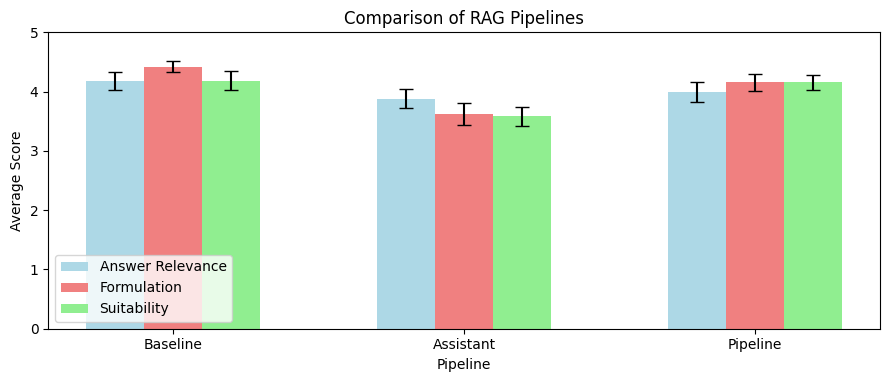

In [127]:
# here I should create a plot of the averages with the error bars
import matplotlib.pyplot as plt

results_df.index = ['Baseline', 'Assistant', 'Pipeline']
standard_errors_df.index = ['Baseline', 'Assistant', 'Pipeline']

# # Plot the data with error bars
# fig, ax = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# metrics = ['answer_relevance', 'formulation', 'suitability']
# titles = ['Answer Relevance', 'Formulation', 'Suitability']
# colors = ['blue', 'orange', 'green']
# pipelines = ['Baseline', 'Assistant', 'Pipeline']

# # print(results_df["answer_relevance"])

# # double check this
# for i, metric in enumerate(metrics):
#     means = results_df[metric]
#     errors = standard_errors_df[metric]
#     ax[i].bar(pipelines, means, yerr=errors, capsize=5, color=colors)
#     ax[i].set_title(titles[i])
#     ax[i].set_ylim(0, 5)
#     ax[i].set_ylabel('Average Score')
#     ax[i].set_xlabel('Pipeline')

# plt.suptitle('Comparison of RAG Pipelines')
# plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# plt.show()

# Define shades of grey and patterns
colors = ['#808080', '#A9A9A9', '#D3D3D3']  # Different shades of grey
hatches = ['/', '\\', '|']  # Different patterns

# Create a single plot
fig, ax = plt.subplots(figsize=(12, 8))

metrics = ['answer_relevance', 'formulation', 'suitability']
titles = ['Answer Relevance', 'Formulation', 'Suitability']
pipelines = ['Baseline', 'Assistant', 'Pipeline']

# Positions for the bars
bar_width = 0.2
positions = np.arange(len(pipelines))
offsets = np.linspace(-bar_width, bar_width, len(metrics))

# Plotting
for i, (metric, title, color, hatch) in enumerate(zip(metrics, titles, colors, hatches)):
    means = [results_df.loc[pipeline, metric] for pipeline in pipelines]
    errors = [standard_errors_df.loc[pipeline, metric] for pipeline in pipelines]
    bars = ax.bar(positions + offsets[i], means, yerr=errors, capsize=5, width=bar_width, color=color, label=title, hatch=hatch)

# Customizing the plot
ax.set_title('Comparison of RAG Pipelines')
ax.set_ylim(0, 5)
ax.set_ylabel('Average Score')
ax.set_xlabel('Pipeline')
ax.set_xticks(positions)
ax.set_xticklabels(pipelines)
ax.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Compute Krippendorf's alpha

In [97]:
import krippendorff

# Prepare data for the Krippendorf calculation

df1 = pd.read_csv("../../evals/human/multi-dimension/results/assistant_results.csv")
df2 = pd.read_csv("../../evals/human/multi-dimension/results/baseline_results.csv")
df3 = pd.read_csv("../../evals/human/multi-dimension/results/pipeline_results.csv")

df = pd.concat([df1, df2, df3], axis=0, ignore_index=True)

# Create three pivot tables, one for each metric (the aggfunc is only used to deal with duplicate question_number-respondent pairs)
pivot_answer_relevance = df.pivot_table(index='respondent', columns='question_number', values='answer_relevance', aggfunc='mean')
pivot_formulation = df.pivot_table(index='respondent', columns='question_number', values='formulation', aggfunc='mean')
pivot_suitability = df.pivot_table(index='respondent', columns='question_number', values='suitability', aggfunc='mean')

# Replace missing values with np.nan
pivot_answer_relevance = pivot_answer_relevance.applymap(lambda x: np.nan if pd.isnull(x) else x)
pivot_formulation = pivot_formulation.applymap(lambda x: np.nan if pd.isnull(x) else x)
pivot_suitability = pivot_suitability.applymap(lambda x: np.nan if pd.isnull(x) else x)

# Convert pivot tables to numpy arrays
array_answer_relevance = pivot_answer_relevance.to_numpy()
array_formulation = pivot_formulation.to_numpy()
array_suitability = pivot_suitability.to_numpy()

verbose = False
if verbose:
    # Print the arrays to check
    print("Answer Relevance Array:")
    print(array_answer_relevance)
    print("\nFormulation Array:")
    print(array_formulation)
    print("\nSuitability Array:")
    print(array_suitability)


/var/folders/_6/wpldr7zj16g6s0l2mb0tl3f00000gn/T/ipykernel_16298/1251106025.py:17: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pivot_answer_relevance = pivot_answer_relevance.applymap(lambda x: np.nan if pd.isnull(x) else x)
/var/folders/_6/wpldr7zj16g6s0l2mb0tl3f00000gn/T/ipykernel_16298/1251106025.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pivot_formulation = pivot_formulation.applymap(lambda x: np.nan if pd.isnull(x) else x)
/var/folders/_6/wpldr7zj16g6s0l2mb0tl3f00000gn/T/ipykernel_16298/1251106025.py:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pivot_suitability = pivot_suitability.applymap(lambda x: np.nan if pd.isnull(x) else x)


In [102]:
# Calculate Krippendorff's alpha for each question
alpha_answer_relevance = krippendorff.alpha(reliability_data=array_answer_relevance, level_of_measurement="ordinal")
alpha_formulation = krippendorff.alpha(reliability_data=array_formulation, level_of_measurement="ordinal")
alpha_suitability = krippendorff.alpha(reliability_data=array_suitability, level_of_measurement="ordinal")

print(alpha_answer_relevance, alpha_formulation, alpha_suitability)

0.020153432197979382 0.1372956309736706 0.3243691954022989
